In [1]:
import io 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ssv2.simulation import BaseSimulation

Let's start by visualizing some little simulations.

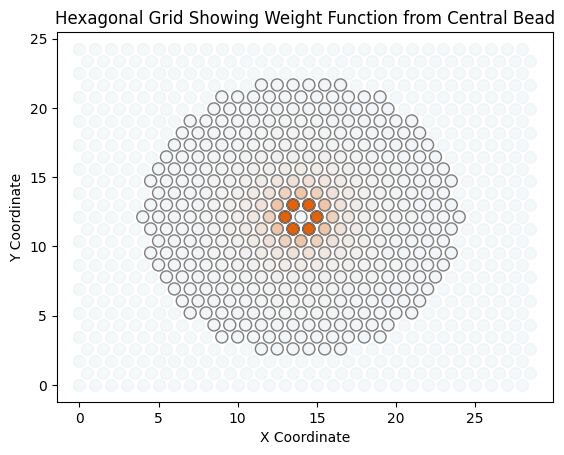

In [2]:
simulator = BaseSimulation(29, 29, max_dispersion_radius=10, max_dispersion_scale=10)

simulator.plot_setting()

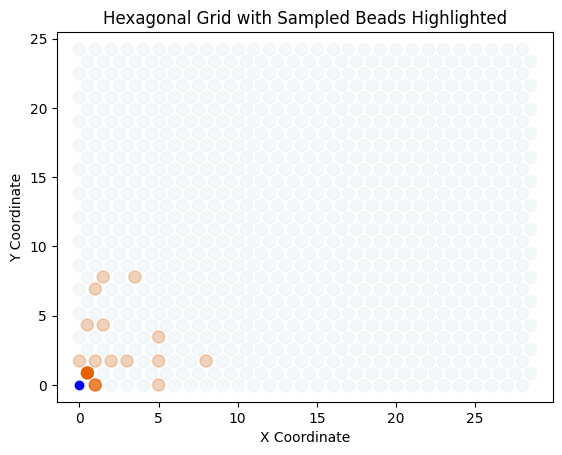

In [3]:
_ = simulator.plot_sample(20, 0)

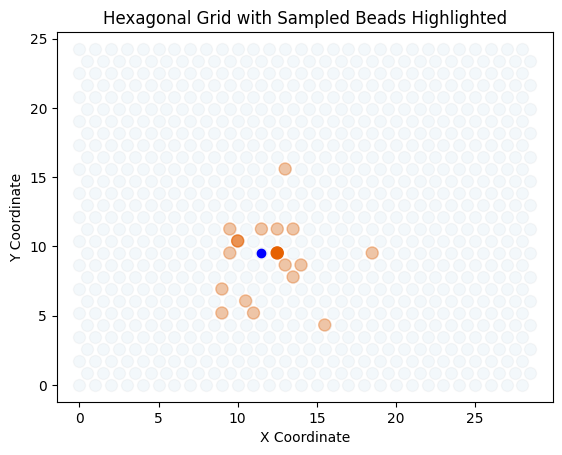

In [4]:
_ = simulator.plot_sample(20, 330)

In [5]:
from PIL import Image

# Generate frames
frames = []
for _ in range(20):
    # This assumes your plot_sample function returns a Figure object
    fig = simulator.plot_sample(200, 130)
    # Convert the Figure object to a PIL Image
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    frame = Image.open(buf)
    frames.append(frame)
    plt.close(fig)  # Close the figure after using it

# Save as an animated GIF
frames[0].save(
    '../_ignore/animation.gif',
    save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0
)

## Big simulation!

In [6]:
read_counts = pd.read_csv('../_data/nextera_interactions_filtered_row_sums.csv', index_col=0).values.squeeze()
read_counts

array([473, 455, 118, ..., 119, 365, 119])

In [7]:
simulator = BaseSimulation(197, 197, max_dispersion_radius=50, max_dispersion_scale=50)
simulated_beads_df = simulator.simulate_experiment(read_counts)
simulated_beads_df.to_csv('../_data/sim.nextera_interactions_filtered.csv.gz', index=False, compression='gzip')

100%|██████████| 38809/38809 [01:54<00:00, 340.12it/s]


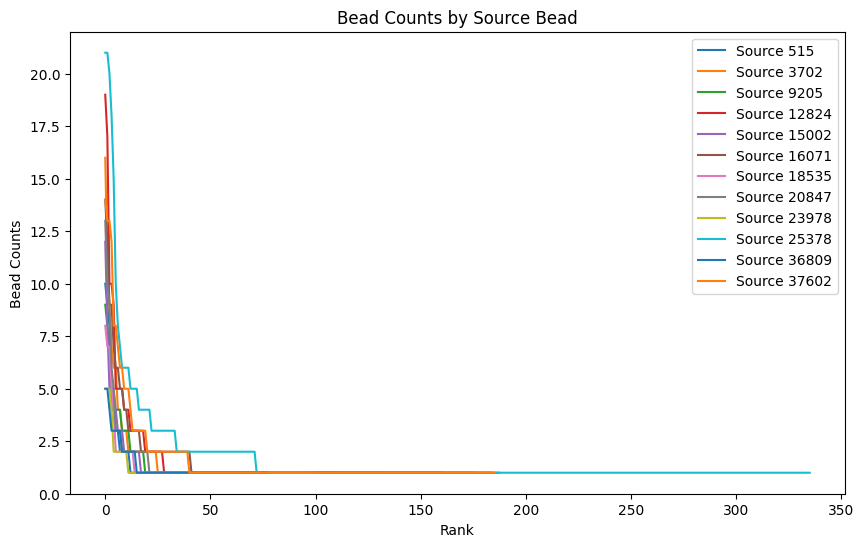

In [8]:
sampled_source_beads = simulated_beads_df['source_bead'].sample(12).unique()
df = simulated_beads_df[simulated_beads_df['source_bead'].isin(sampled_source_beads)]

# Plotting
plt.figure(figsize=(10,6))

for source, group in df.groupby('source_bead'):
    sorted_group = group.sort_values(by='bead_counts', ascending=False)
    plt.plot(sorted_group['bead_counts'].values, label=f'Source {source}')

plt.ylabel('Bead Counts')
plt.xlabel('Rank')
plt.title('Bead Counts by Source Bead')
plt.legend()
plt.show()

In [9]:
simulator.add_coords(simulator.bead_df).to_csv('../_data/sim.nextera_interactions_filtered.coords.csv')